In [1]:
#dbutils.fs.rm("/FileStore/tables/test_features.csv")

# MIE-1628 Final Project Starter Code

## 1. Import libraries

In [4]:
from pyspark.sql import Row
from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from pyspark.sql.types import FloatType
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import udf
from pyspark.sql import functions as F 
from pyspark.sql.functions import explode, col, udf, mean as _mean, stddev as _stddev, log, log10
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.functions import lit


from pyspark.sql.functions import udf, expr, concat, col, count, when, isnan

spark = SparkSession(sc)
sqlc=SQLContext(sc)

## 2. Import data

In [6]:
train_features = sqlc.read.csv('/FileStore/tables/final_project/train_features.csv', header = True,inferSchema=True)

In [7]:
# check all columns and their types
train_features.printSchema()

root
-- sig_id: string (nullable = true)
-- cp_type: string (nullable = true)
-- cp_time: integer (nullable = true)
-- cp_dose: string (nullable = true)
-- g-0: double (nullable = true)
-- g-1: double (nullable = true)
-- g-2: double (nullable = true)
-- g-3: double (nullable = true)
-- g-4: double (nullable = true)
-- g-5: double (nullable = true)
-- g-6: double (nullable = true)
-- g-7: double (nullable = true)
-- g-8: double (nullable = true)
-- g-9: double (nullable = true)
-- g-10: double (nullable = true)
-- g-11: double (nullable = true)
-- g-12: double (nullable = true)
-- g-13: double (nullable = true)
-- g-14: double (nullable = true)
-- g-15: double (nullable = true)
-- g-16: double (nullable = true)
-- g-17: double (nullable = true)
-- g-18: double (nullable = true)
-- g-19: double (nullable = true)
-- g-20: double (nullable = true)
-- g-21: double (nullable = true)
-- g-22: double (nullable = true)
-- g-23: double (nullable = true)
-- g-24: double (nullable = true)
-- g-25: double (nullable = true)
-- g-26: double (nullable = true)
-- g-27: double (nullable = true)
-- g-28: double (nullable = true)
-- g-29: double (nullable = true)
-- g-30: double (nullable = true)
-- g-31: double (nullable = true)
-- g-32: double (nullable = true)
-- g-33: double (nullable = true)
-- g-34: double (nullable = true)
-- g-35: double (nullable = true)
-- g-36: double (nullable = true)
-- g-37: double (nullable = true)
-- g-38: double (nullable = true)
-- g-39: double (nullable = true)
-- g-40: double (nullable = true)
-- g-41: double (nullable = true)
-- g-42: double (nullable = true)
-- g-43: double (nullable = true)
-- g-44: double (nullable = true)
-- g-45: double (nullable = true)
-- g-46: double (nullable = true)
-- g-47: double (nullable = true)
-- g-48: double (nullable = true)
-- g-49: double (nullable = true)
-- g-50: double (nullable = true)
-- g-51: double (nullable = true)
-- g-52: double (nullable = true)
-- g-53: double (nullable = true)
-- g-54: double (nullable = true)
-- g-55: double (nullable = true)
-- g-56: double (nullable = true)
-- g-57: double (nullable = true)
-- g-58: double (nullable = true)
-- g-59: double (nullable = true)
-- g-60: double (nullable = true)
-- g-61: double (nullable = true)
-- g-62: double (nullable = true)
-- g-63: double (nullable = true)
-- g-64: double (nullable = true)
-- g-65: double (nullable = true)
-- g-66: double (nullable = true)
-- g-67: double (nullable = true)
-- g-68: double (nullable = true)
-- g-69: double (nullable = true)
-- g-70: double (nullable = true)
-- g-71: double (nullable = true)
-- g-72: double (nullable = true)
-- g-73: double (nullable = true)
-- g-74: double (nullable = true)
-- g-75: double (nullable = true)
-- g-76: double (nullable = true)
-- g-77: double (nullable = true)
-- g-78: double (nullable = true)
-- g-79: double (nullable = true)
-- g-80: double (nullable = true)
-- g-81: double (nullable = true)
-- g-82: double (nullable = true)
-- g-83: double (nullable = true)
-- g-84: double (nullable = true)
-- g-85: double (nullable = true)
-- g-86: double (nullable = true)
-- g-87: double (nullable = true)
-- g-88: double (nullable = true)
-- g-89: double (nullable = true)
-- g-90: double (nullable = true)
-- g-91: double (nullable = true)
-- g-92: double (nullable = true)
-- g-93: double (nullable = true)
-- g-94: double (nullable = true)
-- g-95: double (nullable = true)
-- g-96: double (nullable = true)
-- g-97: double (nullable = true)
-- g-98: double (nullable = true)
-- g-99: double (nullable = true)
-- g-100: double (nullable = true)
-- g-101: double (nullable = true)
-- g-102: double (nullable = true)
-- g-103: double (nullable = true)
-- g-104: double (nullable = true)
-- g-105: double (nullable = true)
-- g-106: double (nullable = true)
-- g-107: double (nullable = true)
-- g-108: double (nullable = true)
-- g-109: double (nullable = true)
-- g-110: double (nullable = true)
-- g-111: double (nullable = true)
-- g-112: double (nullable = true)
--

## Check Missing Values

In [9]:
# for each feature, compute the total number of missing values
missing_v = train_features.select([count(when(isnan(col), col)).alias(col) for col in train_features.columns])

In [10]:
# filter out features without missing values
def f(x):
  l = len(x)
  missing_value_index = []
  for i in range(l):
    if x[i] != 0:
      missing_value_index.append(i)
  return missing_value_index

a = missing_v.rdd.map(tuple).map(f)
a.take(1)

Out[7]: [[]]

There is no missing values in the data

## EDA

sig_id

In [14]:
# check if sig_id is unique
train_features.select("sig_id").distinct().count() == train_features.count()

Out[8]: True

In [15]:
# drop sig_id
train_cleaned = train_features.drop(train_features.sig_id)

cp_type

In [17]:
# check cp_type unique values
train_cleaned.select("cp_type").distinct().show()

# get the value counts for each cp_type
trt_cp = train_cleaned.select("cp_type").where(train_cleaned.cp_type == 'trt_cp').count()
ctl_vehicle = train_cleaned.select("cp_type").where(train_cleaned.cp_type == 'ctl_vehicle').count()

+-----------+
 cp_type|
+-----------+
 trt_cp|
ctl_vehicle|
+-----------+

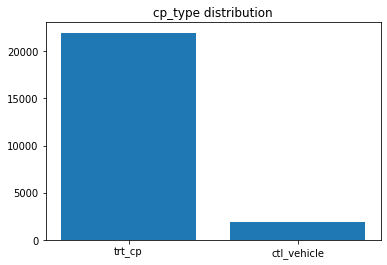

In [18]:
import matplotlib.pyplot as plt
# get distribution of cp_type
plt.bar(['trt_cp', 'ctl_vehicle'], [trt_cp, ctl_vehicle])
plt.title("cp_type distribution")

In [19]:
# convert cp_type to binary feature
train_cleaned = train_cleaned.withColumn("cp_type",expr("case when cp_type = 'trt_cp' then 1 " + "else 0 end"))

cp_time

In [21]:
# check cp_time unique values
train_cleaned.groupBy(train_cleaned.cp_time).count().orderBy('count').show()

# get the value counts for each cp_time
time_value_counts = train_cleaned.groupBy(train_cleaned.cp_time).count().orderBy('count').\
  selectExpr("cp_time as cp_time", "count as _count").collect()

time_values = [int(row.cp_time) for row in time_value_counts]
time_counts = [int(row._count) for row in time_value_counts]

+-------+-----+
cp_time|count|
+-------+-----+
 24| 7772|
 72| 7792|
 48| 8250|
+-------+-----+

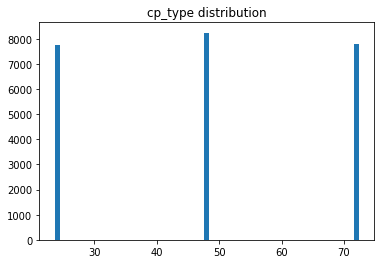

In [22]:
# get distribution of cp_time
plt.bar(time_values, time_counts)
plt.title("cp_type distribution")

## random thoughts / useless for now

In [28]:
columns = train_features.columns
GENES = [col for col in train_features.columns if col.startswith('g-')]

In [30]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors

data = [(Vectors.dense([1.0, 1.0, 3.0, 4.0, 5.0]),),
  (Vectors.dense([2.0, 0.0, 3.0, 4.0, 5.0]),),
  (Vectors.dense([4.0, 0.0, 0.0, 6.0, 7.0]),)]
df = sqlc.createDataFrame(data,["features"])
pca = PCA(
    k = 2, 
    inputCol = 'features', 
    outputCol = 'pcaFeatures'
).fit(df)

df_pca = pca.transform(df)

In [31]:
df_pca.show(truncate=False)

+---------------------+-----------------------------------------+
features |pcaFeatures |
+---------------------+-----------------------------------------+
[1.0,1.0,3.0,4.0,5.0]|[-2.2395101858357522,-1.1631918071279084]|
[2.0,0.0,3.0,4.0,5.0]|[-2.8913643552901243,0.09183255190459771]|
[4.0,0.0,0.0,6.0,7.0]|[-7.411463391188066,-0.6622925741020174] |
+---------------------+-----------------------------------------+